In [93]:
include("../scripts/kf.jl")

draw (generic function with 10 methods)

In [94]:
mutable struct EstimatedLandmark <: AbstractLandmark
    pos
    id
    cov
end

In [95]:
function EstimatedLandmark_()
    self = EstimatedLandmark(ntuple(x->nothing, fieldcount(EstimatedLandmark))...)
    self.pos = [0.0, 0.0]
    self.id = nothing
    self.cov = nothing
    return self
end

EstimatedLandmark_ (generic function with 1 method)

In [96]:
function draw(self::EstimatedLandmark, ax, elems)
    if isnothing(self.cov)
        return
    end
    
    c = ax.scatter(self.pos[1], self.pos[2], s=100, marker="*", label="landmarks", color="blue")
    elems = vcat(elems, c)
    elems = vcat(elems, ax.text( self.pos[1], self.pos[2] , string("id:", string(self.id)), fontsize=10))
    
    e = sigma_ellipse(self.pos, self.cov, 3)
    elems = vcat(elems, [ax.add_patch(e)])

end

draw (generic function with 10 methods)

In [97]:
mutable struct MapParticle <: AbstractParticle
    pose
    weight
    map
end

In [98]:
function MapParticle_(init_pose, weight, landmark_num)
    self = MapParticle(ntuple(x->nothing, fieldcount(MapParticle))...)
    self.pose = init_pose
    self.weight = weight
    self.map = Map()
    
    for i in 1:landmark_num
        append_landmark(self.map, EstimatedLandmark_())
    end
    return self
end

MapParticle_ (generic function with 1 method)

In [115]:
function init_landmark_estimation(self::MapParticle, landmark, z, distance_dev_rate, direction_dev)
    landmark.pos = z[1] * [cos(self.pose[3] + z[2]), sin(self.pose[3] + z[2])] + self.pose[1:2]
    H = matH(self.pose, landmark.pos)[1:2, 1:2]
    Q = matQ(distance_dev_rate*z[1], direction_dev)
    landmark.cov = inv(H'*inv(Q)*H)
end

init_landmark_estimation (generic function with 1 method)

In [116]:
function observation_update(self::MapParticle, observation, distance_dev_rate, direction_dev)
    for d in observation
        z = d[1]
        landmark = self.map.landmarks[d[2] + 1] #1indexed
        if isnothing(landmark.cov)
            init_landmark_estimation(self, landmark, z, distance_dev_rate, direction_dev)
        end
    end
end

observation_update (generic function with 5 methods)

In [117]:
mutable struct FastSlam <: AbstractMcl
    particles
    map
    distance_dev_rate
    direction_dev
    motion_noise_rate_pdf
    ml
    pose
end

In [118]:
function FastSlam_(init_pose, particle_num, landmark_num, motion_noise_stds=Dict("nn"=>0.19, "no"=>0.001, "on"=>0.13, "oo"=>0.2),
        distance_dev_rate=0.14, direction_dev=0.05)
    self = FastSlam(ntuple(x->nothing, fieldcount(FastSlam))...)
    self.particles =[Particle(init_pose, 1.0/particle_num) for i in 1:particle_num]
    self.map = nothing
    self.distance_dev_rate = distance_dev_rate
    self.direction_dev = direction_dev
    v = motion_noise_stds
    c = Diagonal([v["nn"]^2, v["no"]^2, v["on"]^2, v["oo"]^2])
    self.motion_noise_rate_pdf = MvNormal(zeros(4), c)
    self.ml = self.particles[1]
    self.pose = self.ml.pose
    
    self.particles = [MapParticle_(init_pose, 1.0/particle_num, landmark_num) for i in 1:particle_num]
    self.ml = self.particles[1]
    return self
end

FastSlam_ (generic function with 4 methods)

In [119]:
function observation_update(self::FastSlam, observation)
    for p in self.particles
        observation_update(p, observation, self.distance_dev_rate, self.direction_dev)
    end
    set_ml(self)
    resampling(self)
end

observation_update (generic function with 5 methods)

In [120]:
function draw(self::FastSlam, ax, elems)
    xs = [p.pose[1] for p in self.particles]
    ys = [p.pose[2] for p in self.particles]
    vxs = [cos(p.pose[3])*p.weight*length(self.particles) for p in self.particles]
    vys = [sin(p.pose[3])*p.weight*length(self.particles) for p in self.particles]
    elems = vcat(elems, ax.quiver(xs, ys, vxs, vys, angles="xy", scale_units="xy", color="blue", alpha=0.5))
    draw(self.ml.map, ax, elems)
end

draw (generic function with 10 methods)

In [121]:
function trial()
    time_interval = 1.0
    world = World_(30, time_interval, false)
    
    m = Map()
    for ln in [[-4.0, 2.0], [2.0, -3.0], [3.0, 3.0]]
        append_landmark(m, Landmark(ln))
    end
    append(world, m)
    
    initial_pose = [0.0, 0.0, 0.0]
    pf = FastSlam_(initial_pose, 100, length(m.landmarks))
    a = EstimationAgent_(time_interval, 0.2, 10.0/180*pi, pf)
    r = Robot_(initial_pose, sensor=Camera_(m), agent=a, color="red")
    append(world, r)
    draw(world)
    showanim("test.mp4")
end

trial (generic function with 1 method)

<video controls src="data:video/x-m4v;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQACJ8ttZGF0AAACoAYF//+c3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE1NyAtIEguMjY0L01QRUctNCBBVkMgY29kZWMgLSBDb3B5bGVmdCAyMDAzLTIwMTggLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0xMiBsb29rYWhlYWRfdGhyZWFkcz0yIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFjZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJhbWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdlaWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MSBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAAIRFliIQAF//+99S3zLLtU2+2C6j3op4mX0N1JQGblsTtOoAAAAMAAAMAAB68FzgCX4kK868AAAMAyoAXqEn/CmOPiA7BC5NJlvfhKIWPSXi/zA6JYDLoQAMQkginty7NGv2twoUk3+x++sOjYLO23GkLnX3zZEYn6a9vQcRQLf67K7SBvVrJ/o4DfjcfmL80ItpTpOBk9UoqIRYyXX9Jp26SG/qkhzXvDYJnUDUkXMWTV9xgIkId/B0DL63tzWtJoDT3qBLshsubVeON8CDX6ibsLgVVQ4A0D7tGbVkDzT/KsUAH7fA8ber7HvEJfThyzrLkSWNw9QjQzXk0jYHioNxDFOC0u5P/6flbarG27qxKpcR1g3jAe/uyNQkdibir9L1oZNoxCL9nTz5Do7WCxbfdwBz786P6Gt3+a9qFmQoe2Qlbs6zkxnOY8FmvubMXtnqJ20rtvpHrl79t6nq8q+9ZGR6BdRh00t3Aigy2K6jkGX8xF2NbE0107yMuMhNJ8nLf3bEUDA1W0TIui6TwnLCPxsZoeNH9a4AHuu+fRe2d9XIIXx50n+Od5GeJI+w65vIpFM505Ok+93xmUtuVHGQ3eacRH3D3LWgvRa8VlJf0rW/lw3pNMKrLBfC42qBBbPPf9t2q9s/FQBF+eHBqb/CB1m4Za8y+nnzp4tqwGv7FWpgi0iuEQ4W59KBcdz8U2ukqDc8XRyHIGUzQWrN2B2hH41jBxiu8GM2/yYQASZZNk6cnN992hxnRVU/+oJK/JdfpqQC09Qp+0lkF/MADsjxgxnmkyiD4cJFbjyc/bIvgLZswUinp9mbC+OqS+B3Ka9nIBrRd8URZmZnmnn6jGyox4iNCMwrJzVTMejzVjwcpF5gWSDBAd3fPNh4CYMsOqHHJJ1HIr3/3KzKyJnKGIPwD1EjEsKeZY5DEKBN4Lbx26JgmuTA0OP3RbWAeL+ir6H9Mb4x3dd+L7OWOoo4B1KBC4/aaucgK7eEvPBBROiWJKHmvcmGPLENac0h8vpqJiNt8oL+lLovYydPN0MtBOF77qrfXs5yYwVV8wdQeh0IDRZfdLsMfPCuL/cZevHiHPQIcRIiUkZvyn+Uswd/Xo655ExuFM8w3KfRzzViZCzknAHgd+/OoRGxQXJDBDyrmDrnyngS/CHy9++SUAg9YnnH95b6lj8LGffC96zXDqLyljJ4lfIPfe6d+IfkXye/Nl7cHjy6h5C9i6+ZaEFhJPZXVPABmhxxvRtSCNAhGAJEFaRup6P+JvElbas7JOQNjAnIlDJQnEKZ3gcveaikJBrR4E5dgRe2CJ/xToLQ3W3m99xXZzN4df3Xw1HhK7hmfFS4+OK4zSK2mSaYlhIRg4yqJ7hRTTI4A19SbkUpgF+pf6gYZNHuRNU2l1DmrtggDOMj6uZnKBdyPBxbM7koJ83/Skmo/hjlHlItIwGCWtR2Mco+53ozMEciaxFsSULjFIeeeFvwfcqOqlBPTuY4TSSmwdTWmthsz6rJ4DVQTnNJhCdGMHSnbEPe2xvQ1YDqz055wZLxmMknwlLhX4BSVkIZQY2si5LdZGprU737CUUEFFWZFMtdUTPwsrtrwkAJRIeiMma3DMayTCGv97gQPFqWWJMXLlDS2QNKqK7x4zeoMFxtuiny0bW4uy4qxc9Er4VVmReFZPUc68ku68j6BUkuzhhkREyh75jJ8A4uunxUBU8Ep0J/QteN+oP6Rj9eBuSo103m97A49cGjfrN9DqlJzwnYE4BeH5FgW54EHcQKYJVjzYzHN+Yi8dE2DESg3qiMdOxjPfF6GAhMwDBn2yREmUkU9xIRpkftkGWapHjdfYpADCMrcRGlXmcMZGWJeEizloHtUCXga7djZldZl56lr3BWmjSeWuyhKDLHwp1/d1o8v/zQu3FWnMRPXV9YjkhDmyTpCeANyq9dR38fGiDCDwTfJCH2x/+IxpFHaS5zFBjcO6b51fDnrTSbkFqZeYjphJJUCLW/0rJ2cfVXHcA+xjqBe2MeEmie+CDSXQkHvEB6ybrQP8InMU9rkfI53BDZ96JTl0FhDaSmrKnGOhbnJDm2iHtuZh3QkI6tE01ensr3aBjWn822DkeYAiiru+47M5cd9kaypLbrztenpcUL+c79lexp0qNkAvuHmgNDOt8Ofi30zfOdQU0CUj57vtTc4YmUVo84E7hEFO3hZ8060Yq7OmoSas2oYMqPVcd4zpqhLuC6tYw4CrK/1LL7TIi3p56mPXERS/8N3excmGOWKFSo6vkvZ5Rvigksq+LbhpGiMfXqs4yiMt00ZtZbqUSkjQYsRyvWznmwlRIsOFNcGL1Tmq65xeotwH6FqzDwzcF+8dmoadAReZrUUPjulZwFk5XuGYabjFBYUfDzmOmPKXmSTkakD8xmaLemg059JIjMdmK+rI+ov+OrtRzZ8eWZP28pFeeFZnwwtqaFyTAdjYWHqW8l9rF7CeZzFv4a1WxwiMI+0IWGUtP/J2EL0YHyjghfUHayzyB773d1cXD5GGybYk7cDPsEGYmj/wQwYUotSXIBDO13tVI06d/7e+vN193FSz7huDjFJPeQhy+1h7BC9syEtHYm3DmkT2F5QvRO6Hnuq7Ovfogfa+0j7OexCgNkTEBTx5AX5Mpa5eoMajp6VBBaREqlTNDyNYK/zn85BCpkef9Ys/dK96WiyMxTE74IT4j+JYOv+S7XXnpH17hu5OricWbBo3SwwYUH9BENu2bPx2S2bjh2f/0FvsFpcXnrxWjpUxof/dGpA3TXTSyuP33BMmrlFph95R1d6EebDfJkyhAUIj8eOXVy8BdzqyyhL4zwWpF1VTBVDY3Wa+RiG4t7cD54oZfSZ5fMAcaCPJ1MSc5Pim2IEeBrcxhtR5KNHO5GP6zTeP2jhthviIL9G43sNn4CtQ7bBagXmXYPhEQlidF630DGjB53Nv1SEFHO+vSaOmFk/w/3vP7N4nKsjmlkQbN2zJ96p3uy

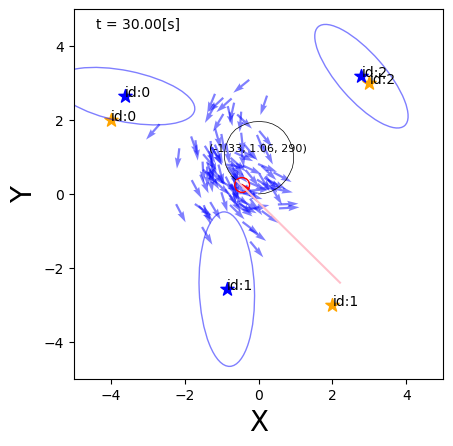

In [122]:
trial()